<a href="https://colab.research.google.com/github/AkarisDimitry/ising_model/blob/main/ising_model_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Ising en 2D

El **modelo de Ising** es uno de los modelos más simples y fundamentales en la física estadística. Describe una red de espines que pueden adoptar dos valores, típicamente \( $+1$ \) (spin arriba) y \( $-1$ \) (spin abajo). Los espines interactúan con sus vecinos más cercanos. La energía de una configuración particular de espines está dada por:

$$
E = -J \sum_{\langle i,j \rangle} s_i s_j
$$

donde \( $J$ \) es una constante de interacción, \( $s_i$ \) es el valor del espín en el sitio \( i \), y la suma \( $\langle i,j \rangle $\) se lleva a cabo sobre todos los pares de vecinos.

## Algoritmo de Metropolis

El **algoritmo de Metropolis** es una técnica Monte Carlo que se utiliza para obtener una muestra de distribuciones de probabilidad. En el contexto del modelo de Ising, lo usamos para simular la evolución del sistema hacia el equilibrio termodinámico.

El algoritmo involucra los siguientes pasos:

1. Elegir un espín al azar.
2. Calcular la energía \( $E_i$ \) de la configuración actual y la energía \( $E_f$ \) de la configuración si se voltea el espín.
3. Si \( $ \Delta E = E_f - E_i \leq 0$ \), voltee el espín. Si \($ \Delta E > 0 $\), voltee el espín con una probabilidad \( $P = \exp(-\beta \Delta E)$ \), donde \( $\beta$ \) es \( $1/kT$ \) y \( $k $\) es la constante de Boltzmann y \( T \) es la temperatura.
4. Repita los pasos anteriores muchas veces.

## Implementación en Python

En la implementación dada, inicializamos dos redes de espines: una con el 75% de espines negativos y otra con el 75% de espines positivos. Utilizamos la librería `numba` para optimizar el rendimiento del algoritmo de Metropolis y `scipy.ndimage` para calcular la energía utilizando convolución.

El algoritmo de Metropolis se implementa en la función `metropolis`, que toma como entrada una red de espines, el número de pasos de tiempo para la simulación, el valor de \($ \beta J$ \), y la energía inicial de la red.

Las funciones `get_energy` y `get_spin_energy` se utilizan para calcular la energía de una configuración de espines y para obtener la magnetización y energía promedio de la red a lo largo de una simulación, respectivamente.

Finalmente, visualizamos la evolución de la magnetización y la energía del sistema utilizando `matplotlib`.


# 2D Ising Model

The **Ising model** is one of the simplest and most fundamental models in statistical physics. It describes a lattice of spins that can take on two values, typically \( $+1$ \) (spin up) and \( $-1$ \) (spin down). Spins interact with their nearest neighbors. The energy of a particular spin configuration is given by:

\[$
E = -J \sum_{\langle i,j \rangle} s_i s_j
$\]

where \( $J $\) is a coupling constant, \( $s_i$ \) is the value of the spin at site \($ i $\), and the sum \($ \langle i,j \rangle$ \) runs over all neighbor pairs.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure


## Spin Lattice Initialization

Next, we initialize two spin lattices. One where 75% of the spins are negative and another where 75% of the spins are positive. The visualization of the lattice helps to see the initial spin configuration.


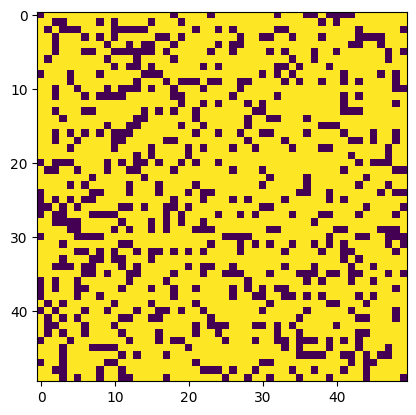

In [3]:

# Setting up a 50 by 50 grid.
# This will represent our two-dimensional lattice of spins.
N = 50

# Initializing a lattice where 75% of spins are negative.
# In the Ising model, spins can either be up (+1) or down (-1).
# The probability distribution is chosen arbitrarily here for demonstration.
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

# Initializing another lattice where 75% of spins are positive.
init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

# Display the lattice of positive spins.
# This visualization helps to see the initial configuration of spins.
plt.imshow(lattice_p)



## Energy Computation

We define a function to compute the energy of the lattice based on the interactions between neighboring spins.


In [4]:
# Function to calculate the energy of the given lattice.
# The energy is computed based on interactions between neighboring spins.
def get_energy(lattice):
    # Generate a kernel to apply the nearest neighbors summation.
    # In the Ising model, a spin's energy is influenced by its immediate neighbors.
    kern = generate_binary_structure(2, 1)
    kern[1][1] = False
    # Calculate the energy using convolution. The energy is determined by the interaction between each spin and its neighbors.
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()


## Metropolis Algorithm

The **Metropolis algorithm** is a Monte Carlo technique used to sample from probability distributions. We use this algorithm to simulate the system's evolution towards thermodynamic equilibrium. Below, we define the Metropolis algorithm and apply it to our spin lattice.


In [5]:

# Metropolis algorithm, a Monte Carlo method.
# It's used to simulate the system and move it towards equilibrium.
# The algorithm involves randomly selecting spins and deciding whether to flip them based on the change in energy.
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    # Making a copy of the input array.
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        # Randomly pick a point in the array and propose a spin flip.
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] # Initial spin.
        spin_f = spin_i*-1 # Proposed spin flip.

        # Calculate the change in energy if the spin at this point were flipped.
        E_i = 0
        E_f = 0
        # Account for neighboring spins in the energy calculations.
        # The energy change is based on interactions between the chosen spin and its neighbors.
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]

        # Decide whether to flip the spin based on Metropolis criteria.
        # This criteria takes into account the change in energy and temperature of the system.
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE

        # Store the net spin and energy for this iteration.
        # This helps in tracking the evolution of the system over time.
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy

    return net_spins, net_energy

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Visualization of Evolution

We'll visualize how the system's magnetization and energy evolve over time. These plots provide valuable insights into the system's behavior and properties.


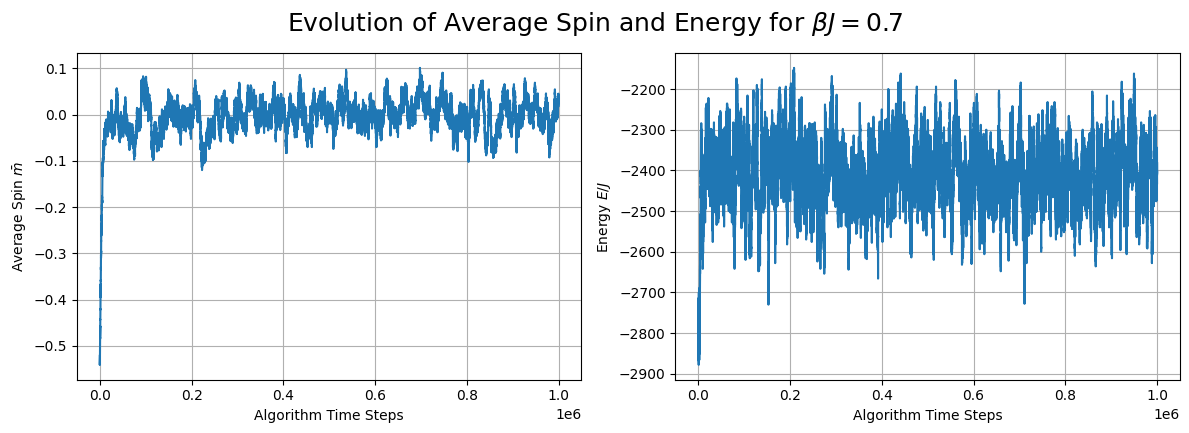

In [7]:
# Run the Metropolis algorithm on the negative spin lattice.
# This simulation will help us understand how the system evolves towards equilibrium.
spins, energies = metropolis(lattice_n, 1000000, 0.2, get_energy(lattice_n))

# Plot the results.
# By observing the average spin and energy, we can deduce properties like magnetization and phase transitions.
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.7', y=1.07, size=18)
plt.show()

## Temperature Analysis

We'll examine how different temperatures (represented by values of \( \beta J \)) affect the system's behavior. This analysis allows for a better understanding of phase transitions and other critical phenomena in the Ising model.


In [8]:

# Function to compute the average spin and energy over a range of BJ values.
# By studying these values, we can understand how different temperatures (BJ values) affect the system's behavior.
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 1000000, bj, get_energy(lattice))
        ms[i] = spins[-100000:].mean()/N**2
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds

BJs = np.arange(0.1, 2, 0.05)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)


## Visualization of Average Spins and Heat Capacity

These plots showcase the system's average magnetization and heat capacity as a function of temperature. They assist in identifying critical points and phase transitions in the model.


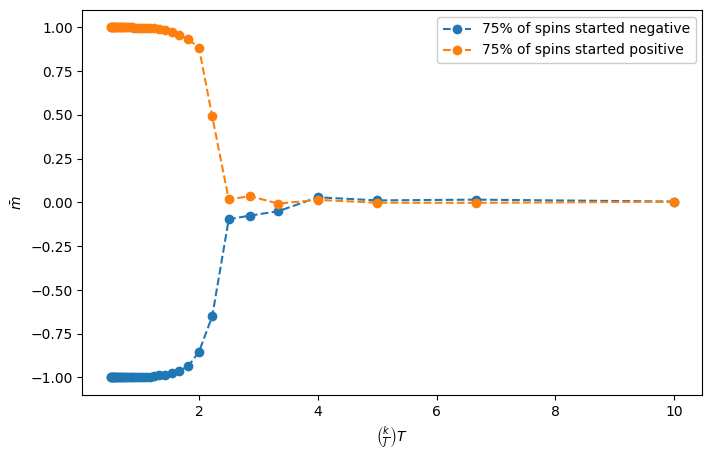

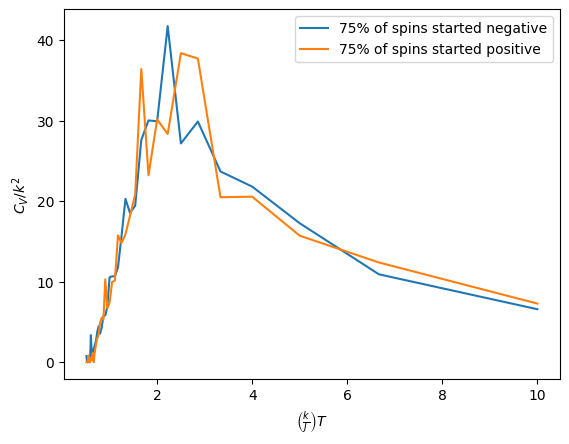

In [9]:


# Plot the average spins.
# This plot reveals the average magnetization of the system for different temperatures.
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

# Plot the heat capacities.
# Heat capacity reveals how the energy of the system fluctuates with temperature.
# Peaks in the heat capacity can indicate phase transitions.
plt.plot(1/BJs, E_stds_n*BJs, label='75% of spins started negative')
plt.plot(1/BJs, E_stds_p*BJs, label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()
